In [1]:
import pennylane as qml
from matplotlib import pyplot as plt
from pennylane import numpy as np
import scipy
import networkx as nx
import copy

In [2]:
qubit_number = 4
qubits = range(qubit_number)

Edges: [(0, 1), (0, 3), (1, 2), (2, 3)]


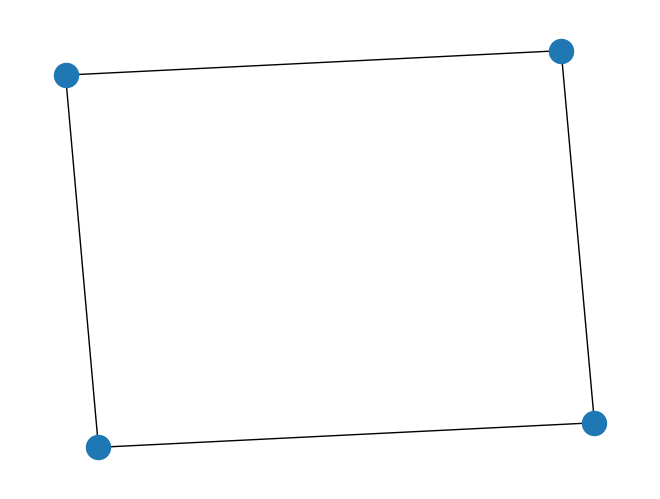

In [3]:
ising_graph = nx.cycle_graph(qubit_number)

print(f"Edges: {ising_graph.edges}")
nx.draw(ising_graph)

In [4]:
target_weights = [0.56, 1.24, 1.67, -0.79]
target_bias = [-1.44, -1.43, 1.18, -0.93]

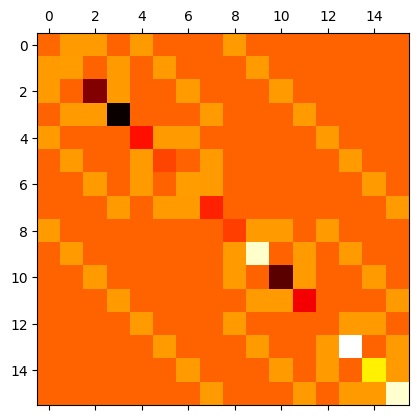

In [5]:
def create_hamiltonian_matrix(n_qubits, graph, weights, bias):

    full_matrix = np.zeros((2 ** n_qubits, 2 ** n_qubits))

    # Creates the interaction component of the Hamiltonian
    for i, edge in enumerate(graph.edges):
        interaction_term = 1
        for qubit in range(0, n_qubits):
            if qubit in edge:
                interaction_term = np.kron(interaction_term, qml.matrix(qml.PauliZ)(0))
            else:
                interaction_term = np.kron(interaction_term, np.identity(2))
        full_matrix += weights[i] * interaction_term

    # Creates the bias components of the matrix
    for i in range(0, n_qubits):
        z_term = x_term = 1
        for j in range(0, n_qubits):
            if j == i:
                z_term = np.kron(z_term, qml.matrix(qml.PauliZ)(0))
                x_term = np.kron(x_term, qml.matrix(qml.PauliX)(0))
            else:
                z_term = np.kron(z_term, np.identity(2))
                x_term = np.kron(x_term, np.identity(2))
        full_matrix += bias[i] * z_term + x_term

    return full_matrix


# Prints a visual representation of the Hamiltonian matrix
ham_matrix = create_hamiltonian_matrix(qubit_number, ising_graph, target_weights, target_bias)
plt.matshow(ham_matrix, cmap="hot")
plt.show()

In [8]:
low_energy_state = [
    (-0.054661080280306085 + 0.016713907320174026j),
    (0.12290003656489545 - 0.03758500591109822j),
    (0.3649337966440005 - 0.11158863596657455j),
    (-0.8205175732627094 + 0.25093231967092877j),
    (0.010369790825776609 - 0.0031706387262686003j),
    (-0.02331544978544721 + 0.007129899300113728j),
    (-0.06923183949694546 + 0.0211684344103713j),
    (0.15566094863283836 - 0.04760201916285508j),
    (0.014520590919500158 - 0.004441887836078486j),
    (-0.032648113364535575 + 0.009988590222879195j),
    (-0.09694382811137187 + 0.02965579457620536j),
    (0.21796861485652747 - 0.06668776658411019j),
    (-0.0027547112135013247 + 0.0008426289322652901j),
    (0.006193695872468649 - 0.0018948418969390599j),
    (0.018391279795405405 - 0.005625722994009138j),
    (-0.041350974715649635 + 0.012650711602265649j),
]

In [9]:
res = np.vdot(low_energy_state, (ham_matrix @ low_energy_state))
energy_exp = np.real_if_close(res)
print(f"Energy Expectation: {energy_exp}")


ground_state_energy = np.real_if_close(min(np.linalg.eig(ham_matrix)[0]))
print(f"Ground State Energy: {ground_state_energy}")

Energy Expectation: -7.244508985189116
Ground State Energy: -7.330689661291244


In [10]:
def state_evolve(hamiltonian, qubits, time):

    U = scipy.linalg.expm(-1j * hamiltonian * time)
    qml.QubitUnitary(U, wires=qubits)

In [11]:
def qgrnn_layer(weights, bias, qubits, graph, trotter_step):

    # Applies a layer of RZZ gates (based on a graph)
    for i, edge in enumerate(graph.edges):
        qml.MultiRZ(2 * weights[i] * trotter_step, wires=(edge[0], edge[1]))

    # Applies a layer of RZ gates
    for i, qubit in enumerate(qubits):
        qml.RZ(2 * bias[i] * trotter_step, wires=qubit)

    # Applies a layer of RX gates
    for qubit in qubits:
        qml.RX(2 * trotter_step, wires=qubit)

In [12]:
def swap_test(control, register1, register2):

    qml.Hadamard(wires=control)
    for reg1_qubit, reg2_qubit in zip(register1, register2):
        qml.CSWAP(wires=(control, reg1_qubit, reg2_qubit))
    qml.Hadamard(wires=control)

Edges: [(4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


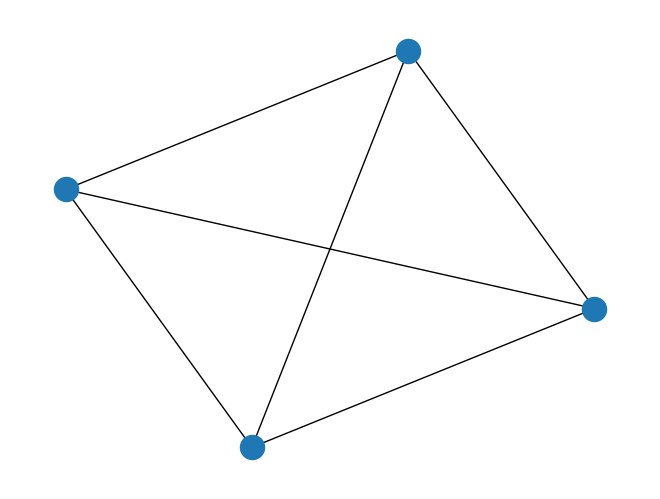

In [13]:
# Defines some fixed values

reg1 = tuple(range(qubit_number))  # First qubit register
reg2 = tuple(range(qubit_number, 2 * qubit_number))  # Second qubit register

control = 2 * qubit_number  # Index of control qubit
trotter_step = 0.01  # Trotter step size

# Defines the interaction graph for the new qubit system

new_ising_graph = nx.complete_graph(reg2)

print(f"Edges: {new_ising_graph.edges}")
nx.draw(new_ising_graph)

In [14]:
def qgrnn(weights, bias, time=None):

    # Prepares the low energy state in the two registers
    qml.StatePrep(np.kron(low_energy_state, low_energy_state), wires=reg1 + reg2)

    # Evolves the first qubit register with the time-evolution circuit to
    # prepare a piece of quantum data
    state_evolve(ham_matrix, reg1, time)

    # Applies the QGRNN layers to the second qubit register
    depth = time / trotter_step  # P = t/Delta
    for _ in range(0, int(depth)):
        qgrnn_layer(weights, bias, reg2, new_ising_graph, trotter_step)

    # Applies the SWAP test between the registers
    swap_test(control, reg1, reg2)

    # Returns the results of the SWAP test
    return qml.expval(qml.PauliZ(control))

In [15]:
N = 15  # The number of pieces of quantum data that are used for each step
max_time = 0.1  # The maximum value of time that can be used for quantum data

In [16]:
rng = np.random.default_rng(seed=42)

def cost_function(weight_params, bias_params):

    # Randomly samples times at which the QGRNN runs
    times_sampled = rng.random(size=N) * max_time

    # Cycles through each of the sampled times and calculates the cost
    total_cost = 0
    for dt in times_sampled:
        result = qgrnn_qnode(weight_params, bias_params, time=dt)
        total_cost += -1 * result

    return total_cost / N

In [17]:
# Defines the new device
qgrnn_dev = qml.device("default.qubit", wires=2 * qubit_number + 1)

# Defines the new QNode
qgrnn_qnode = qml.QNode(qgrnn, qgrnn_dev)

steps = 300

optimizer = qml.AdamOptimizer(stepsize=0.5)

weights = rng.random(size=len(new_ising_graph.edges), requires_grad=True) - 0.5
bias = rng.random(size=qubit_number, requires_grad=True) - 0.5

initial_weights = copy.copy(weights)
initial_bias = copy.copy(bias)

In [18]:
for i in range(0, steps):
    (weights, bias), cost = optimizer.step_and_cost(cost_function, weights, bias)

    # Prints the value of the cost function
    if i % 5 == 0:
        print(f"Cost at Step {i}: {cost}")
        print(f"Weights at Step {i}: {weights}")
        print(f"Bias at Step {i}: {bias}")
        print("---------------------------------------------")

Cost at Step 0: -0.9803638573791906
Weights at Step 0: [-0.22603613  0.43887001  0.85859236  0.69735898  0.09417125 -0.02437147]
Bias at Step 0: [-0.23884748 -0.21392016  0.12809368  0.45037793]
---------------------------------------------
Cost at Step 5: -0.9974589524428032
Weights at Step 5: [-0.75106068  1.078707    0.83766935  1.9741555   0.04982793 -0.06747815]
Bias at Step 5: [-0.50836435 -1.32708118  1.57468372  0.11442806]
---------------------------------------------
Cost at Step 10: -0.9971878268304798
Weights at Step 10: [ 0.01577799  0.48771566  0.68379977  1.75747002 -0.21948418 -0.00484698]
Bias at Step 10: [ 0.22007905 -0.90282076  1.58989008 -0.1051542 ]
---------------------------------------------
Cost at Step 15: -0.998187153312274
Weights at Step 15: [-0.06744249  0.65720464  1.31471457  1.47430241  0.05813038 -0.41315658]
Bias at Step 15: [-0.29045223 -0.67045595  1.19395446  0.24677711]
---------------------------------------------
Cost at Step 20: -0.99951306921

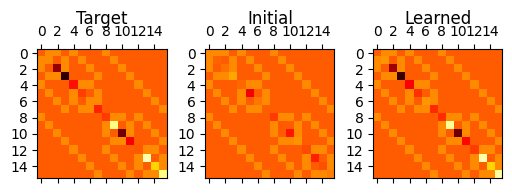

In [20]:
new_ham_matrix = create_hamiltonian_matrix(
    qubit_number, nx.complete_graph(qubit_number), weights, bias
)

init_ham = create_hamiltonian_matrix(
    qubit_number, nx.complete_graph(qubit_number), initial_weights, initial_bias
)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 6))

axes[0].matshow(ham_matrix, vmin=-7, vmax=7, cmap="hot")
axes[0].set_title("Target", y=1.13)

axes[1].matshow(init_ham, vmin=-7, vmax=7, cmap="hot")
axes[1].set_title("Initial", y=1.13)

axes[2].matshow(new_ham_matrix, vmin=-7, vmax=7, cmap="hot")
axes[2].set_title("Learned", y=1.13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [21]:
# We first pick out the weights of edges (1, 3) and (2, 0)
# and then remove them from the list of target parameters

weights_noedge = []
weights_edge = []
for ii, edge in enumerate(new_ising_graph.edges):
    if (edge[0] - qubit_number, edge[1] - qubit_number) in ising_graph.edges:
        weights_edge.append(weights[ii])
    else:
        weights_noedge.append(weights[ii])

In [22]:
print("Target parameters     Learned parameters")
print("Weights")
print("-" * 41)
for ii_target, ii_learned in zip(target_weights, weights_edge):
    print(f"{ii_target : <20}|{ii_learned : >20}")

print("\nBias")
print("-"*41)
for ii_target, ii_learned in zip(target_bias, bias):
    print(f"{ii_target : <20}|{ii_learned : >20}")

print(f"\nNon-Existing Edge Parameters: {[val.unwrap() for val in weights_noedge]}")

Target parameters     Learned parameters
Weights
-----------------------------------------
0.56                |  0.5988034096092855
1.24                |  1.3483865512005277
1.67                |  1.7862070648455757
-0.79               | -0.8425475506159186

Bias
-----------------------------------------
-1.44               | -1.4067983643944169
-1.43               | -1.3529638627173954
1.18                |  1.0349129419830896
-0.93               | -1.0635874966599632

Non-Existing Edge Parameters: [-0.001265147192823957, -0.0036534472423259785]
